<a href="https://colab.research.google.com/github/Craig-UK/artificial-intelligence/blob/main/StockPreBasedOffModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pystan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 KB 3.3 MB/s eta 0:00:00


In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import datetime as dt
import yfinance as yf
yf.pdr_override()
from pandas_datareader import data as web

start = dt.datetime(2020, 1, 1)
end = dt.datetime.now()

data = web.get_data_yahoo("ATVI", start, end)

data.to_csv("stock_data.csv")

[*********************100%***********************]  1 of 1 completed


In [ ]:
data = pd.read_csv("stock_data.csv")

In [ ]:
data = data[["Date", "Close"]]

In [ ]:
data

,Date,Close
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
812,2023-03-24,84.389999
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001


In [ ]:
data.columns = ["ds", "y"]

In [ ]:
data

,ds,y
0,2020-01-02,58.650002
1,2020-01-03,58.669998
2,2020-01-06,59.740002
3,2020-01-07,60.340000
4,2020-01-08,59.880001
...,...,...
812,2023-03-24,84.389999
813,2023-03-27,84.330002
814,2023-03-28,84.349998
815,2023-03-29,84.540001


In [ ]:
from prophet import Prophet

In [ ]:
prophet = Prophet(daily_seasonality=True)
prophet.fit(data)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpp13m0g6g/uw3f76rc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp13m0g6g/xrvzpd11.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36991', 'data', 'file=/tmp/tmpp13m0g6g/uw3f76rc.json', 'init=/tmp/tmpp13m0g6g/xrvzpd11.json', 'output', 'file=/tmp/tmpp13m0g6g/prophet_model9imcen4q/prophet_model-20230330150529.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future_dates = prophet.make_future_dataframe(periods=30)
predictions = prophet.predict(future_dates)

In [ ]:
from prophet.plot import plot_plotly

plot_plotly(prophet, predictions)

In [ ]:
pred_month = predictions["yhat"][-30:]

In [ ]:
old_arr = []
for x in pred_month:
  old_arr.append(x)
old_arr

[79.29973947391952,
 79.4823022390719,
 79.66767402590168,
 79.87125072615122,
 80.01018400889234,
 80.03256738762637,
 80.17811886001337,
 80.34098716716606,
 80.39091423207103,
 80.4294029131044,
 80.47502758351114,
 80.44833443383466,
 80.30095552518631,
 80.27621608610026,
 80.2718637970628,
 80.16115436254134,
 80.04894424821423,
 79.95692979564373,
 79.80848123161226,
 79.55769710021177,
 79.44995995473188,
 79.38462320975825,
 79.23606439432173,
 79.10975638733149,
 79.02749629747352,
 78.91224069113755,
 78.71717261570979,
 78.68628091054087,
 78.71708110674345,
 78.68171231850974]

In [ ]:
import numpy as np, numpy.random
value = np.random.dirichlet((95, 5), 30).transpose()
value *= 3
same_one = []

for i,x in enumerate(pred_month):
  if i == 0:
    same_one.append(x)
  else:
    same_one.append(x + value[0][i])
same_one

[79.29973947391952,
 82.38529546730048,
 82.61393194067784,
 82.81233314385105,
 82.80888668755176,
 82.93863604200305,
 83.06316983358437,
 83.17430318105097,
 83.23031046435317,
 83.24144995110862,
 83.2482284353954,
 83.34512782788791,
 83.16977754914058,
 83.17123482307977,
 82.9914796131466,
 83.05175874681349,
 82.91609764229675,
 82.77321581704147,
 82.6501958171348,
 82.30845268271689,
 82.39164887365595,
 82.25274644001637,
 82.10172054272388,
 81.97711774288149,
 81.81165303120274,
 81.82562984909958,
 81.60132420707843,
 81.56519194759836,
 81.38592531008932,
 81.49870468371329]

<Axes: >

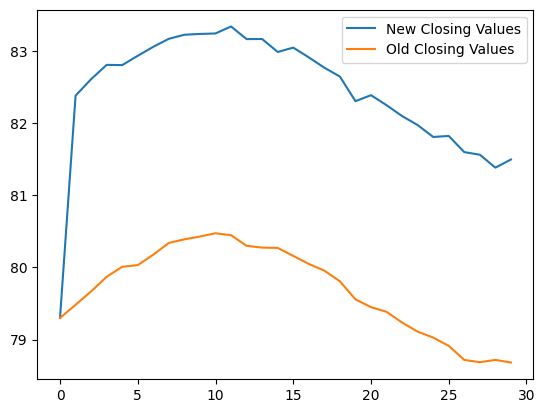

In [ ]:
new_preds = pd.DataFrame(same_one, columns = ["New Closing Values"])
old_preds = pd.DataFrame(old_arr, columns = ["Old Closing Values"])
df_merged = pd.concat([new_preds, old_preds], axis=1)
df_merged.plot()